# Sberbank Russian Housing Market

In this competition, Sberbank is challenging Kagglers to develop algorithms which use a broad spectrum of features to predict realty prices. 

Competitors will rely on a rich dataset that includes housing data and macroeconomic patterns. 

An accurate forecasting model will allow Sberbank to provide more certainty to their customers in an uncertain economy.

## Steps to access any dataset on Kaggle via the API

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /content/.cache/pip/wheels/98/be/57/a576a1f2f50f5c3bebd0c08fc3b2a6881dfde31c8217014978
Successfully built kaggle


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
imagenet-object-detection-challenge             2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-detection-from-video-challenge  2029-12-31 07:00:00  Research         Knowledge          0           False  
imagenet-object-localization-challenge          2029-12-31 07:00:00  Research         Knowledge          8           False  
titanic                                         2020-04-07 00:00:00  Getting Started  Knowledge      11259           False  
house-prices-advanced-regression-techniques     2020-03-01 23:59:00  Getting Started  Knowledge       5348            True  
digit-recognizer                                2020-01-07 00:00:00  Getting Started  Knowledge       2443           False  


In [5]:
!mkdir data && kaggle competitions download -c sberbank-russian-housing-market -p data/

macro.csv.zip: Downloaded 72KB of 72KB
sample_submission.csv.zip: Downloaded 19KB of 19KB
test.csv.zip: Downloaded 4MB of 4MB
train.csv.zip: Downloaded 17MB of 17MB
data_dictionary.txt: Downloaded 25KB of 25KB


## Unzipping data set from Kaggle




In [6]:
!cd data && unzip test.csv.zip && unzip train.csv.zip && unzip sample_submission.csv.zip && unzip macro.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
   creating: __MACOSX/
  inflating: __MACOSX/._test.csv     
Archive:  train.csv.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  macro.csv.zip
  inflating: macro.csv               


In [7]:
PATH = "data"
files = os.listdir(PATH)
files

['macro.csv.zip',
 'test.csv',
 '__MACOSX',
 'sample_submission.csv',
 'train.csv.zip',
 'train.csv',
 'test.csv.zip',
 'sample_submission.csv.zip',
 'macro.csv',
 'data_dictionary.txt']

# Data Exploration

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

### Format for sample submission

In [9]:
df_submit = pd.read_csv(f'{PATH}/sample_submission.csv')

#Display the first five rows to get a feel of the data
df_submit.head()

,id,price_doc
0,30474,7118500.41
1,30475,7118500.41
2,30476,7118500.41
3,30477,7118500.41
4,30478,7118500.41


### Training set

In [10]:
df_train = pd.read_csv(f'{PATH}/train.csv')
df_train.shape

(30471, 292)

In [11]:
#Display the first five rows to get a feel of the training data
df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

### Test set

In [12]:
df_test = pd.read_csv(f'{PATH}/test.csv')
print(df_test.shape)

(7662, 291)


In [13]:
#Display the first five rows to get a feel of the test data
df_test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

# Target variable exploration - 'price_doc'. 

First let us do a scatter plot to see if there are any outliers in the data.

In [14]:
#descriptive statistics summary
df_train['price_doc'].describe()

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

In [15]:
#skewness and kurtosis
print("Skewness: %f" % df_train['price_doc'].skew())

Skewness: 4.474745


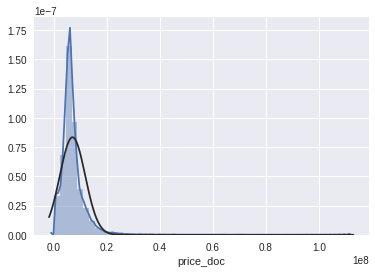

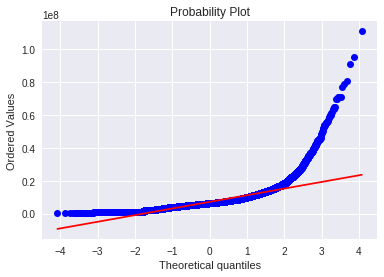

In [16]:
#histogram and normal probability plot
sns.distplot(df_train['price_doc'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['price_doc'], plot=plt)

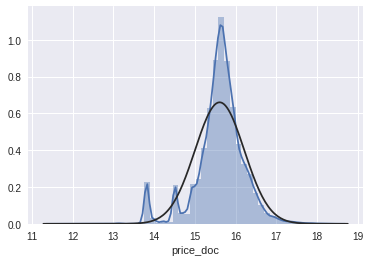

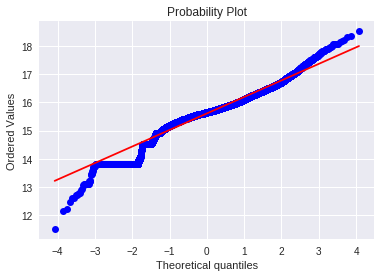

In [17]:
#apply log-transform on the 'price_doc' target variable
#histogram and normal probability plot
sns.distplot(np.log(df_train['price_doc']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(df_train['price_doc']), plot=plt)

## Median housing price change with time

In [0]:
df_train['yearmonth'] = df_train['timestamp'].apply(lambda x: x[:4]+x[5:7])
df_grouped = df_train.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

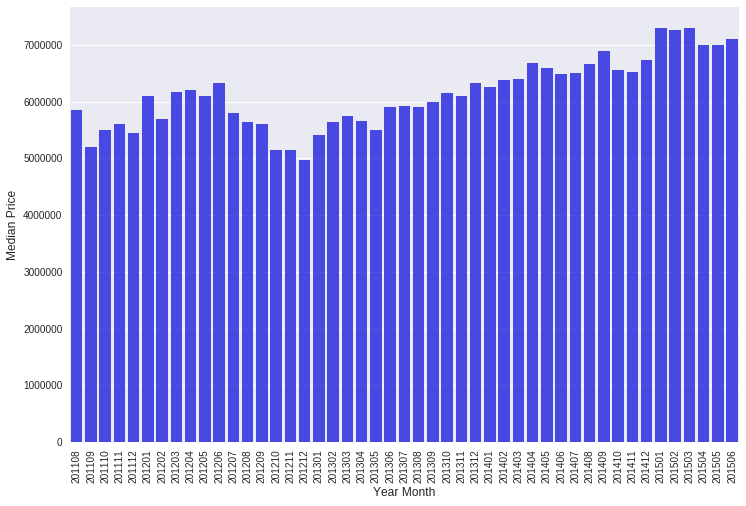

In [19]:
plt.figure(figsize=(12,8))
sns.barplot(df_grouped.yearmonth.values, df_grouped.price_doc.values, alpha=0.8, color='blue')
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

There are some variations in the median price with respect to time. Towards the end, there seems to be some linear increase in the price values.

Now let us dive into other variables and see. Let us first start with getting the count of different data types.

### Features data-type

In [20]:
train_df = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,157
1,datetime64[ns],1
2,float64,119
3,object,15


Majority of the features are continuous variables. The remainders with 15 factor variables and 1 date variable.

### Missing values

In [0]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count'] 

In [22]:
# less than 1000 missing values 
impute_df =  missing_df.ix[missing_df['missing_count']>0]
impute_df = impute_df.ix[impute_df['missing_count']<1000]
print(len(impute_df))
impute_df

13


,column_name,missing_count
4,floor,167
87,metro_min_walk,25
88,metro_km_walk,25
97,railroad_station_walk_km,25
98,railroad_station_walk_min,25
99,ID_railroad_station_walk,25
252,cafe_sum_3000_min_price_avg,991
253,cafe_sum_3000_max_price_avg,991
254,cafe_avg_price_3000,991
269,prom_part_5000,178


In [23]:
# more than 1000 missing values
delete_df = missing_df.ix[missing_df['missing_count']>=1000]
print(len(delete_df))
delete_df

38


,column_name,missing_count
3,life_sq,6383
5,max_floor,9572
6,material,9572
7,build_year,13605
8,num_room,9572
9,kitch_sq,9572
10,state,13559
18,preschool_quota,6688
21,school_quota,6685
24,hospital_beds_raion,14441


Some variables appears to have missing values in groups.

# Feature Understanding

## Data Quality Issues

In [0]:
# state should be discrete valued between 1 and 4. There is a 33 in it that is cleary a data entry error
# Lets just replace it with the mode.
df_train.loc[df_train.state == 33, 'state'] = df_train['state'].mode()

In [25]:
df_train['state'].describe()

count    16911.000000
mean         2.105198
std          0.847505
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: state, dtype: float64

## Housing Internal Characteristics

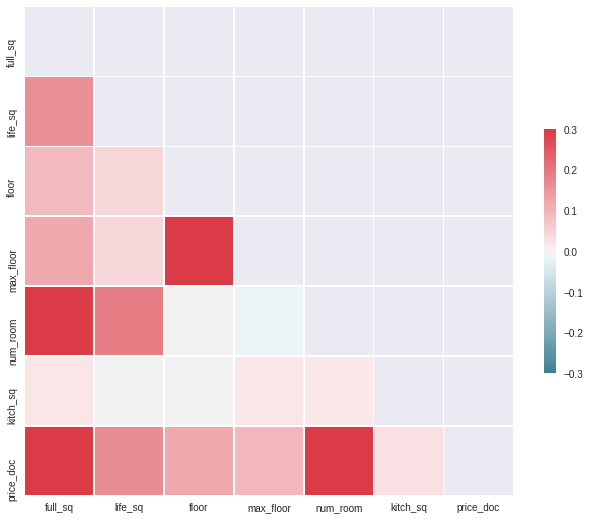

In [31]:
# calculate the correlation matrix
corr = df_train.loc[:, ['full_sq', 'life_sq', 'floor', 'max_floor', 'num_room', 'kitch_sq', 'price_doc'] ].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,full_sq,life_sq,floor,max_floor,num_room,kitch_sq,price_doc
full_sq,1,0.16,0.09,0.12,0.7,0.02,0.34
life_sq,0.16,1,0.045,0.042,0.19,0.00063,0.17
floor,0.09,0.045,1,0.45,-0.0057,-0.0085,0.12
max_floor,0.12,0.042,0.45,1,-0.014,0.02,0.094
num_room,0.7,0.19,-0.0057,-0.014,1,0.017,0.48
kitch_sq,0.02,0.00063,-0.0085,0.02,0.017,1,0.029
price_doc,0.34,0.17,0.12,0.094,0.48,0.029,1


### House size and Number of Rooms


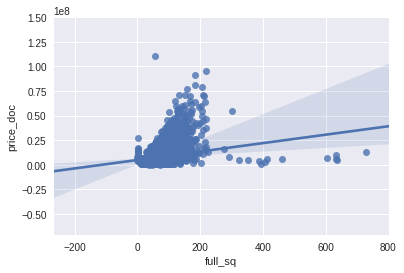

In [36]:
# price_doc versus full_sq
sns.regplot(x = df_train['full_sq'], y = df_train["price_doc"])
plt.xlim(right=800)
plt.ylim(top=1.5e8)
sns.plt.show()

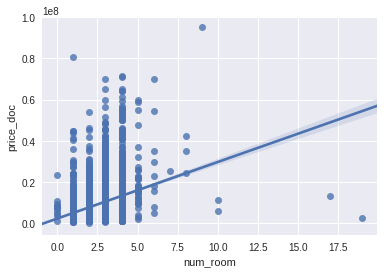

In [37]:
# price_doc versus num_room
sns.regplot(x = df_train['num_room'], y = df_train["price_doc"])
sns.plt.show()

### Demographic Characteristics

Now let’s move beyond the internal home characteristics and take a look at some of the basic demographic and geographic characteristics.

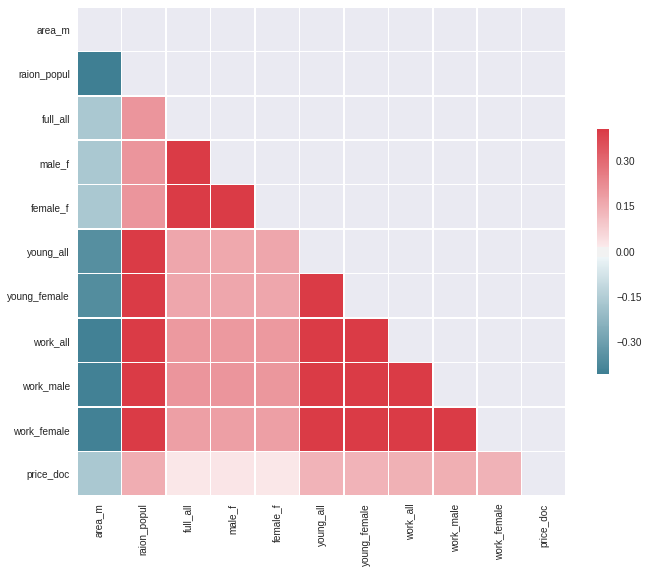

In [38]:
# calculate the correlation matrix
corr = df_train.loc[:, ['area_m', 'raion_popul', 'full_all', 'male_f', 'female_f', 'young_all', 'young_female', 'work_all', 'work_male', 'work_female', 'price_doc'] ].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [39]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,area_m,raion_popul,full_all,male_f,female_f,young_all,young_female,work_all,work_male,work_female,price_doc
area_m,1,-0.4,-0.16,-0.16,-0.16,-0.35,-0.36,-0.4,-0.4,-0.4,-0.17
raion_popul,-0.4,1,0.2,0.2,0.2,0.96,0.96,1,0.99,0.99,0.15
full_all,-0.16,0.2,1,1,1,0.16,0.16,0.19,0.2,0.18,0.025
male_f,-0.16,0.2,1,1,1,0.16,0.16,0.19,0.2,0.18,0.026
female_f,-0.16,0.2,1,1,1,0.16,0.17,0.19,0.2,0.18,0.024
young_all,-0.35,0.96,0.16,0.16,0.16,1,1,0.96,0.95,0.96,0.14
young_female,-0.36,0.96,0.16,0.16,0.17,1,1,0.96,0.95,0.96,0.14
work_all,-0.4,1,0.19,0.19,0.19,0.96,0.96,1,1,1,0.14
work_male,-0.4,0.99,0.2,0.2,0.2,0.95,0.95,1,1,0.99,0.15
work_female,-0.4,0.99,0.18,0.18,0.18,0.96,0.96,1,0.99,1,0.14


### School Characteristics

In the Singapore, school quality is one of the primary determinants of home values. Let’s see if something similar is true in Russia.

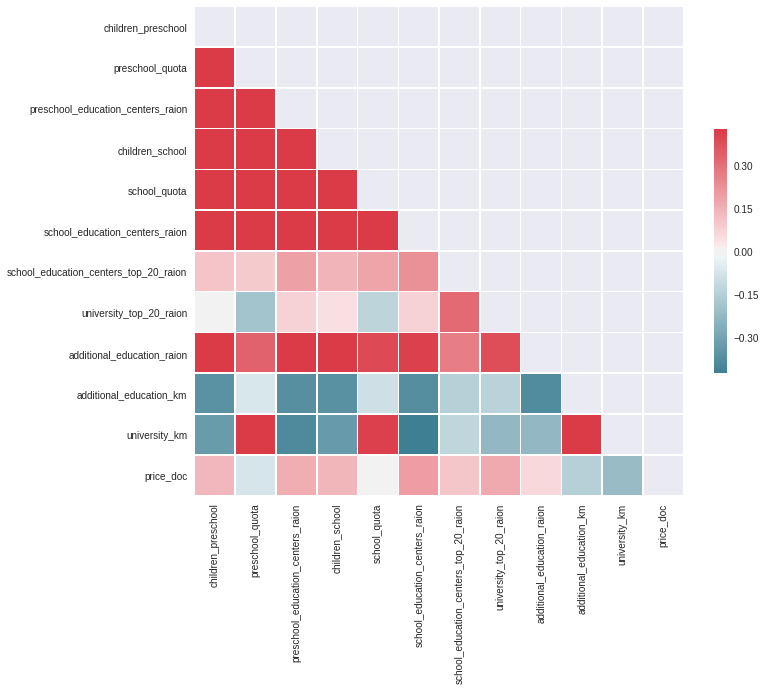

In [40]:
# calculate the correlation matrix
corr = df_train.loc[:, ['children_preschool', 'preschool_quota', 'preschool_education_centers_raion',
                        'children_school', 'school_quota', 'school_education_centers_raion', 
                        'school_education_centers_top_20_raion', 'university_top_20_raion',
                        'additional_education_raion', 'additional_education_km', 'university_km',
                        'price_doc'] ].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [41]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,university_top_20_raion,additional_education_raion,additional_education_km,university_km,price_doc
children_preschool,1,0.83,0.85,0.99,0.85,0.83,0.1,-0.0036,0.46,-0.36,-0.32,0.13
preschool_quota,0.83,1,0.81,0.81,0.93,0.73,0.091,-0.19,0.33,-0.069,0.44,-0.075
preschool_education_centers_raion,0.85,0.81,1,0.83,0.85,0.96,0.19,0.075,0.46,-0.37,-0.39,0.16
children_school,0.99,0.81,0.83,1,0.84,0.81,0.14,0.044,0.48,-0.36,-0.33,0.14
school_quota,0.85,0.93,0.85,0.84,1,0.79,0.18,-0.13,0.39,-0.091,0.41,-0.014
school_education_centers_raion,0.83,0.73,0.96,0.81,0.79,1,0.22,0.074,0.41,-0.37,-0.43,0.19
school_education_centers_top_20_raion,0.1,0.091,0.19,0.14,0.18,0.22,1,0.32,0.27,-0.15,-0.12,0.1
university_top_20_raion,-0.0036,-0.19,0.075,0.044,-0.13,0.074,0.32,1,0.38,-0.14,-0.23,0.17
additional_education_raion,0.46,0.33,0.46,0.48,0.39,0.41,0.27,0.38,1,-0.38,-0.23,0.058
additional_education_km,-0.36,-0.069,-0.37,-0.36,-0.091,-0.37,-0.15,-0.14,-0.38,1,0.61,-0.15


Surprisingly, there is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.

### Cultural/Recreational Characteristics

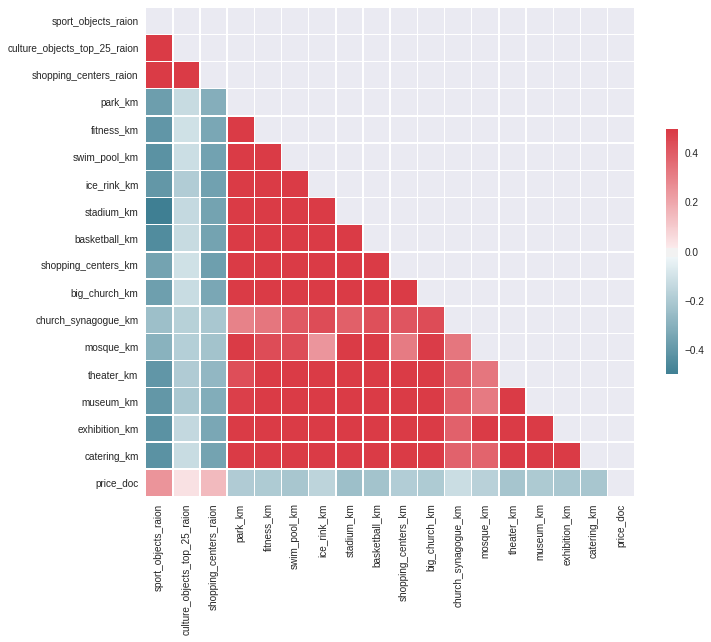

In [42]:
# calculate the correlation matrix
corr = df_train.loc[:, ['sport_objects_raion', 'culture_objects_top_25_raion', 'shopping_centers_raion',                        
                        'park_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km','stadium_km', 'basketball_km',                   
                        'shopping_centers_km', 'big_church_km','church_synagogue_km', 'mosque_km', 'theater_km',                 
                        'museum_km', 'exhibition_km', 'catering_km', 'price_doc'] ].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [43]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,sport_objects_raion,culture_objects_top_25_raion,shopping_centers_raion,park_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,shopping_centers_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,price_doc
sport_objects_raion,1,0.57,0.74,-0.37,-0.4,-0.42,-0.4,-0.5,-0.44,-0.35,-0.37,-0.24,-0.29,-0.4,-0.4,-0.42,-0.42,0.25
culture_objects_top_25_raion,0.57,1,0.59,-0.13,-0.1,-0.12,-0.18,-0.13,-0.13,-0.1,-0.12,-0.17,-0.18,-0.19,-0.2,-0.14,-0.12,0.044
shopping_centers_raion,0.74,0.59,1,-0.31,-0.33,-0.35,-0.36,-0.35,-0.35,-0.37,-0.34,-0.21,-0.22,-0.27,-0.31,-0.34,-0.35,0.15
park_km,-0.37,-0.13,-0.31,1,0.65,0.71,0.52,0.81,0.86,0.61,0.77,0.3,0.79,0.44,0.48,0.84,0.5,-0.19
fitness_km,-0.4,-0.1,-0.33,0.65,1,0.77,0.62,0.65,0.73,0.66,0.76,0.34,0.45,0.61,0.65,0.6,0.62,-0.19
swim_pool_km,-0.42,-0.12,-0.35,0.71,0.77,1,0.78,0.7,0.81,0.9,0.91,0.41,0.45,0.66,0.75,0.74,0.68,-0.21
ice_rink_km,-0.4,-0.18,-0.36,0.52,0.62,0.78,1,0.66,0.72,0.77,0.76,0.45,0.25,0.7,0.75,0.66,0.58,-0.15
stadium_km,-0.5,-0.13,-0.35,0.81,0.65,0.7,0.66,1,0.91,0.64,0.72,0.39,0.62,0.67,0.65,0.91,0.58,-0.24
basketball_km,-0.44,-0.13,-0.35,0.86,0.73,0.81,0.72,0.91,1,0.77,0.84,0.44,0.65,0.71,0.75,0.89,0.6,-0.22
shopping_centers_km,-0.35,-0.1,-0.37,0.61,0.66,0.9,0.77,0.64,0.77,1,0.88,0.42,0.32,0.64,0.75,0.69,0.56,-0.18


### Infrastructure Features

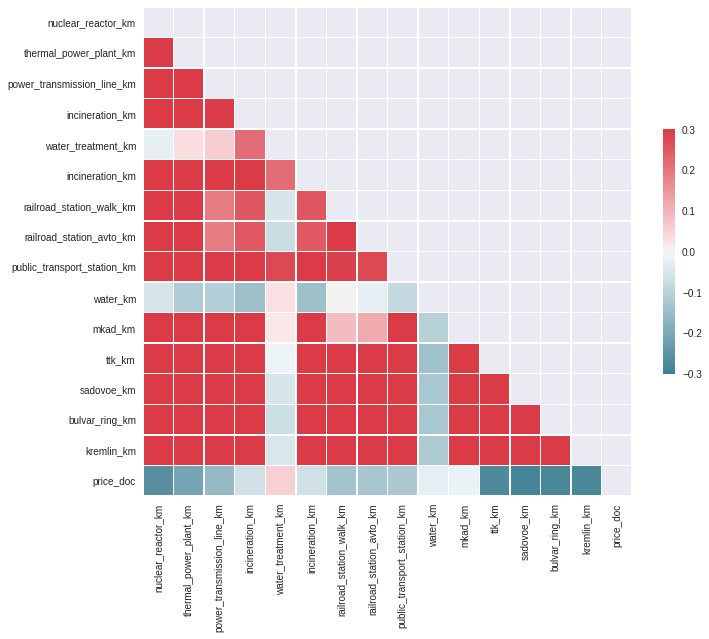

In [50]:
# calculate the correlation matrix
corr = df_train.loc[:, ['nuclear_reactor_km', 'thermal_power_plant_km', 'power_transmission_line_km',
                        'incineration_km','water_treatment_km', 'incineration_km', 'railroad_station_walk_km',                   
                        'railroad_station_avto_km', 'public_transport_station_km', 'water_km',                          
                        'mkad_km', 'ttk_km', 'sadovoe_km','bulvar_ring_km', 'kremlin_km', 'price_doc'] ].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Importance

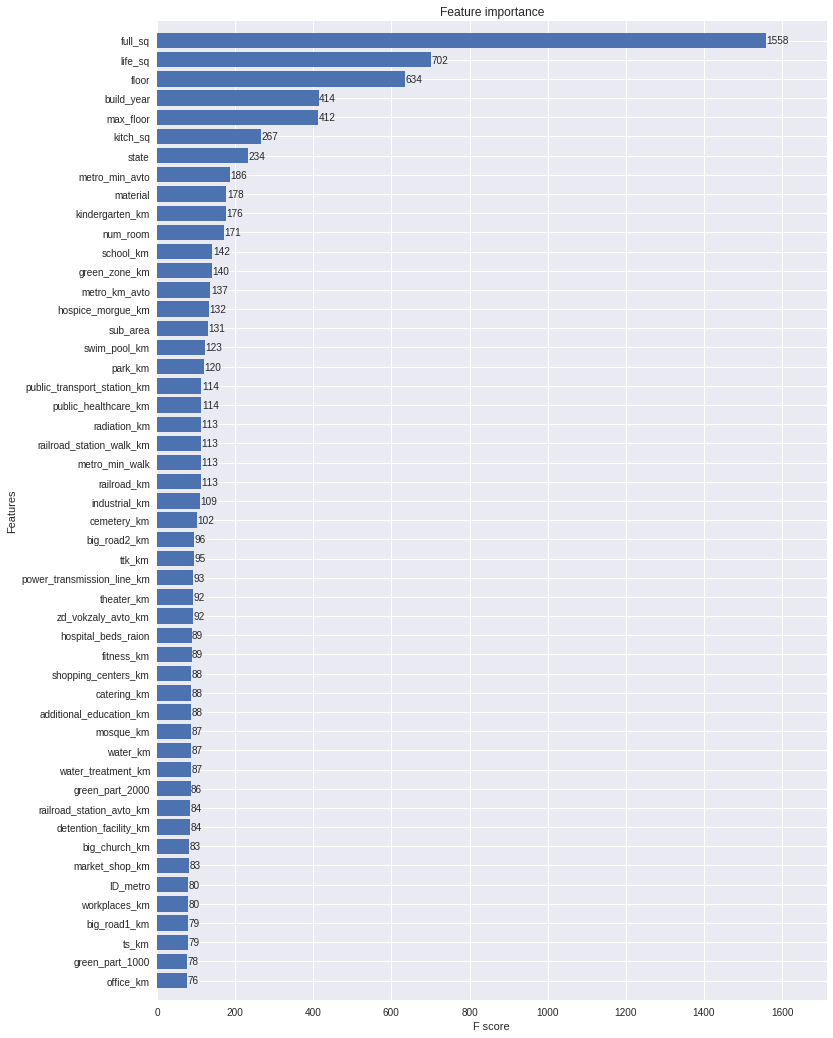

In [0]:
from sklearn import preprocessing
import xgboost as xgb

for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()